## Introduction

* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a **Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**


## Table of Contents
1. [Importing dependencies](#p1)
2. [Importing dataset](#p2)
3. [Preprocessing Text](#p3)
4. [Analysing data](#p4)
5. [Splitting data](#p5)
6. [TF-IDF Vectoriser](#p6)
7. [Transforming Dataset](#p7)
8. [Creating and Evaluating Models](#p8)
9. [Saving the Models](#p9)
10. [Using the Model](#p10)

## <a name="p1">Importing Dependencies</a>

In [9]:
# utilities
import re
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## <a name="p2">Importing dataset</a>
The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.
 
*[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]*

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

We require only the **sentiment** and **text** fields, so we discard the rest.

Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment. **(0 = Negative, 1 = Positive)**

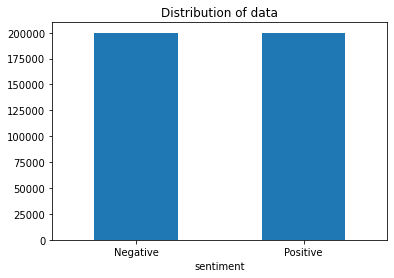

In [10]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('./reduced_dataset.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## <a name="p3">Preprocess Text</a>
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

In [11]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [12]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [13]:
# Depending on your machine, this step may take a long time (up to a minute)
print("Preprocessing...")
processedtext = preprocess(text)
print("Preprocessing complete.")

Preprocessing...
Preprocessing complete.


## <a name="p5">Exercise 1: Splitting the Data</a>

Next, we will split the preprocessed data into training and test data. Do you remember what function we used for this?

Divide **processedtext** (the "X variable") into: 
* **X_train:** the preprocessed text for **training** data
* **X_test:** the preprocessed text for **test** data

Divide **sentiment** (the "y variable") into:
* **y_train:** the labelled sentiments for **training** data
* **y_test:** the labelled sentiments for **test** data

The test data should be 5% of your total data. You can specify this using a special keyword argument in your function (you'll want to read the function documentation!)

In [14]:
# YOUR CODE HERE


print(f'Data Split done.')

Data Split done.


## <a name="p6">TF-IDF Vectoriser</a>
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**.

1. Instantiate a TfidfVectorizer object with the following arguments:

**ngram_range** is the range of number of words in a sequence. **Set ngram_range to (1,2).**
<br>*[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]* 

**max_features** specifies the number of features to consider. **Set max_features to 500000.**

## <a name="p7">Bonus Exercise: Fit TF-IDF Vectoriser</a>

1. Instantiate a TfidfVectorizer object with the following arguments:

**ngram_range** is the range of number of words in a sequence. **Set ngram_range to (1,2).**
<br>*[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]* 

**max_features** specifies the number of features to consider. **Set max_features to 500000.**

2. Fit your vectorizer object to X_train using a built-in method of the TfidfVectorizer class.

In [15]:
print("Fitting vectoriser...")
#YOUR CODE HERE


print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Fitting vectoriser...
Vectoriser fitted.


NameError: name 'vectoriser' is not defined

### <a name="p7">Exercise 2: Transforming the dataset</a>
Transforming the **X_train** and **X_test** dataset into matrix of **TF-IDF Features** by using the **TF-IDF Vectoriser**. These datasets will be used to train the model and test against it.

Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to find a built-in method of TF-IDF Vectoriser to transform these datasets.

In [16]:
print("Transforming data...")
# YOUR CODE HERE


print(f'Data Transformed.')

Transforming data...
Data Transformed.


## <a name="p8">Creating and Evaluating Models</a>

We're using the Bernoulli Naive Bayes model for our sentiment analysis problem.

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative** Predictions. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Evaluate Model Function

In [17]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### <a name="p8-1">Exercise 3: Fitting BernoulliNB Model</a>
We will be using the Bernoulli Naive Bayes classifier as our sentiment analysis model.

Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) for sklearn's BernoulliNB model to:
1. Instantiate a BernoulliNB object with parameter alpha=2 and call your model object BNBmodel.

2. Fit your BNBmodel object on your training data.

3. Evaluate your model using the model_Evaluate function defined above.

In [18]:
# YOUR CODE HERE



### <a name="p8-1">Exercise 4: Understanding Confusion Matrix</a>
The model_Evaluate function produces a confusion matrix that provides data about your model's accuracy. Answer the following questions:

1. What do each of the quadrants mean?
2. What is the overall accuracy of your model?

## <a name="p10">Using the Model.</a>

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **LR Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [21]:
def analyse_sentiment(text):
    # Text to classify should be in a list.
    
    textdata = vectoriser.transform(preprocess(text))
    sentiment = BNBmodel.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])

    print(df)

## Enter your text below

Note: Text to classify should be in a list

In [22]:
analyse_sentiment(["electron"])

NameError: name 'vectoriser' is not defined